
# 📌 Loan Approval Prediction Internship Task  
This notebook demonstrates a complete **Machine Learning pipeline** for predicting loan approval status.  
It follows these steps:
1. Import Libraries  
2. Load Dataset from KaggleHub  
3. Data Cleaning & Preprocessing  
4. Split Train/Test Data  
5. Build Pipeline (Preprocessing + Model)  
6. Train & Evaluate Model  
7. Save & Load Model  
8. Predict on New Applicant  


## Step 1: Import Required Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import kagglehub
import os, glob, zipfile


## Step 2: Download Dataset from Kaggle using KaggleHub

In [2]:

path = kagglehub.dataset_download("ninzaami/loan-predication")
print("Path to dataset files:", path)

print("Files inside downloaded dataset folder:")
for f in glob.glob(os.path.join(path, "*")):
    print(" -", f)


Using Colab cache for faster access to the 'loan-predication' dataset.
Path to dataset files: /kaggle/input/loan-predication
Files inside downloaded dataset folder:
 - /kaggle/input/loan-predication/train_u6lujuX_CVtuZ9i (1).csv


## Step 3: Extract dataset (if zipped) and load CSV

In [3]:

zips = glob.glob(os.path.join(path, "*.zip"))
if zips:
    print("Found zip file:", zips[0])
    with zipfile.ZipFile(zips[0], 'r') as z:
        z.extractall(path)
    print("Zip extracted.")

csvs = glob.glob(os.path.join(path, "*.csv"))
print("CSV files found:", csvs)

df = pd.read_csv(csvs[0])
print("Dataset shape:", df.shape)
df.head()


CSV files found: ['/kaggle/input/loan-predication/train_u6lujuX_CVtuZ9i (1).csv']
Dataset shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Step 4: Data Cleaning & Preprocessing

In [4]:

df = df.drop("Loan_ID", axis=1)

df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
df["Married"].fillna(df["Married"].mode()[0], inplace=True)
df["Dependents"].fillna(df["Dependents"].mode()[0], inplace=True)
df["Self_Employed"].fillna(df["Self_Employed"].mode()[0], inplace=True)
df["Credit_History"].fillna(df["Credit_History"].mode()[0], inplace=True)
df["LoanAmount"].fillna(df["LoanAmount"].median(), inplace=True)
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].median(), inplace=True)

df["Loan_Status"] = df["Loan_Status"].map({"Y": 1, "N": 0})

print("✅ Missing values handled!")
df.info()


✅ Missing values handled!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


/tmp/ipython-input-818790173.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
/tmp/ipython-input-818790173.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

## Step 5: Split Features (X) and Target (y)

In [5]:

X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (491, 11)
Test shape: (123, 11)


## Step 6: Build Pipeline (Preprocessor + Model)

In [6]:

categorical = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]
numerical = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
print("✅ Model training complete!")


✅ Model training complete!


## Step 7: Model Evaluation

🎯 Accuracy: 0.8130081300813008

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67        38
           1       0.84      0.91      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.81      0.81      0.81       123



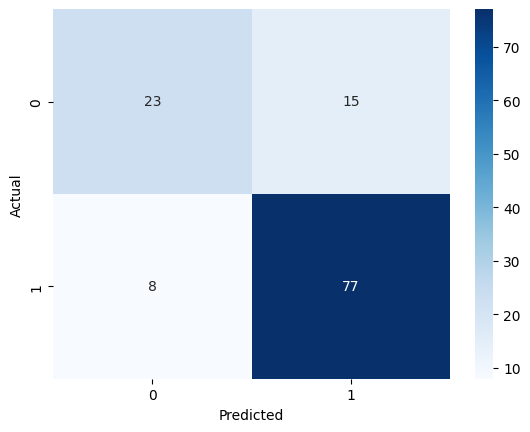

In [7]:

y_pred = pipeline.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Step 8: Save & Load Model

In [8]:

joblib.dump(pipeline, "loan_approval_pipeline.pkl")
print("✅ Model saved as loan_approval_pipeline.pkl")

loaded_model = joblib.load("loan_approval_pipeline.pkl")
print("✅ Model loaded successfully!")


✅ Model saved as loan_approval_pipeline.pkl
✅ Model loaded successfully!


## Step 9: Predict on New Applicant

In [9]:

sample = pd.DataFrame([{
    "Gender": "Male",
    "Married": "Yes",
    "Dependents": "0",
    "Education": "Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 5000,
    "CoapplicantIncome": 2000,
    "LoanAmount": 150,
    "Loan_Amount_Term": 360,
    "Credit_History": 1.0,
    "Property_Area": "Urban"
}])

prediction = loaded_model.predict(sample)[0]
print("✅ Loan Status Prediction:", "Approved ✅" if prediction == 1 else "Rejected ❌")


✅ Loan Status Prediction: Approved ✅
